# Import

In [2]:
import numpy as np
import pandas as pd
import os
import cv2 as cv
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy
import math
import random
from glob import glob

import torch
import torchvision
from torchvision import datasets, models
from torchvision.utils import draw_bounding_boxes
from torchvision.transforms import transforms as T


from pycocotools.coco import COCO
from roboflow import Roboflow

import albumentations as A
from albumentations.pytorch import ToTensorV2

# Preparation
### Load Data from Roboflow

In [3]:
if not os.path.exists("maskdetection-3"):
    print("Downloading dataset...")
    rf = Roboflow(api_key="RLpF5qnVG3u4wi0Hgkmg")
    project = rf.workspace("diza-febriyan-hasal").project("maskdetection-tdrvn")
    dataset = project.version(3).download("coco")

### Coret-coretan MCT

In [ ]:
coco = COCO(os.path.join("maskdetection-3", "train", "_annotations.coco.json"))
anotasi_img = coco.loadAnns(coco.getAnnIds(0))
print(anotasi_img)
print(anotasi_img[0]["bbox"])

### Data Reader

In [4]:
class MaskDetection(datasets.VisionDataset):

    """
    MaskDetection Datareader
    Return:
        - image pixels as tensor
        - annotation as dictionary
    """

    def __init__(self, root, split="train"):
        self.root = root
        self.split = split
        self.transforms = ToTensorV2()
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json"))
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, idx: int):
        id = self.ids[idx]
        anotasi_img = self.coco.loadAnns(self.coco.getAnnIds(idx))
        imgpath = self.coco.loadImgs(id)[0]["file_name"]
        image = cv.imread(os.path.join(self.root, self.split, imgpath))
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        image = self.transforms(image=image)["image"]

        # xmin = anotasi_img[0]["bbox"][0]
        # ymin = anotasi_img[0]["bbox"][1]
        # xmax = xmin + anotasi_img[0]["bbox"][2]  # NOTE: Ubah menjadi xmax ymax
        # ymax = ymin + anotasi_img[0]["bbox"][3]

        my_annotation = {}
        my_annotation["boxes"] = [
            [
                anotasi_img[0]["bbox"][0],
                anotasi_img[0]["bbox"][1],
                anotasi_img[0]["bbox"][2],
                anotasi_img[0]["bbox"][3],
            ]
        ]
        my_annotation["image_id"] = id
        return image.div(255), my_annotation

    def __len__(self):
        return len(self.ids)

In [5]:
dataset_path = "maskdetection-3"
train_dataset = MaskDetection(root=dataset_path, split="train")
val_dataset = MaskDetection(root=dataset_path, split="valid")
test_dataset = MaskDetection(root=dataset_path, split="test")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


### Cek Ombak DataReadernya 
> Sengaja di random, supaya gambarnya ganti-ganti

- Bounding box digambar pakai `import matplotlib.patches as patches` supaya lebih gampang

{'boxes': [[26, 28, 27.979375000000005, 18.030625]], 'image_id': 866}
[[26, 28, 27.979375000000005, 18.030625]]


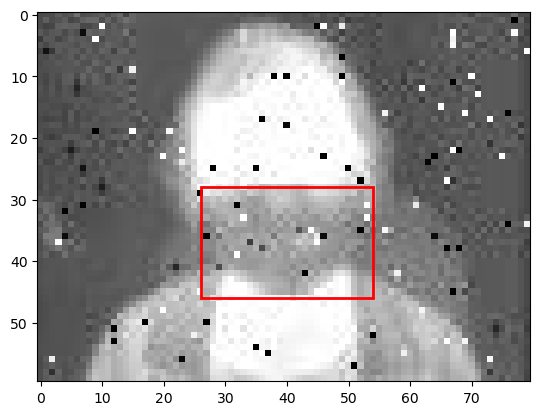

In [6]:
image_sample = train_dataset[random.randint(0, len(train_dataset))]
image_pixels = image_sample[0]
image_ann = image_sample[1]
print(image_ann)

plt.imshow(image_pixels.permute(1, 2, 0))
print(image_ann["boxes"])
rect = patches.Rectangle(
    (image_ann["boxes"][0][0], image_ann["boxes"][0][1]),
    image_ann["boxes"][0][2],
    image_ann["boxes"][0][3],
    linewidth=2,
    edgecolor="r",
    facecolor="none",
)
plt.gca().add_patch(rect)
plt.show()